<a href="https://colab.research.google.com/github/adsk2050/btp-iitg/blob/master/3DFEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
import math, shutil, os, csv
import numpy as np
import scipy as sp
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
np.set_printoptions(precision=1, linewidth=10000)
import time


class Material:
    def __init__(self, c11, c12, c13, c14, c15, c16, c21, c22, c23, c24, c25, c26, c31, c32, c33, c34, c35, c36, c41, c42, c43, c44, c45, c46, c51, c52, c53, c54, c55, c56, c61, c62, c63, c64, c65 ,c66):
        """ 
        creates C matrix 
        sigma = [sig11, sig22, sig33, tau12, tau23, tau31]T
        epsilon = [e11, e22, e33, gam12, gam23, gam31]T
        """
        self.C = np.array([[c11, c12, c13, c14, c15, c16],
                           [c21, c22, c23, c24, c25, c26],
                           [c31, c32, c33, c34, c35, c36],
                           [c41, c42, c43, c44, c45, c46],
                           [c51, c52, c53, c54, c55, c56],
                           [c61, c62, c63, c64, c65, c66]])
        
class Node:
    def __init__(self, x, y, z, gi):
        """ gi is the global index of the node """
        self.x = x
        self.y = y
        self.z = z
        self.gi =gi

class Element:
    """ 
    We don't have body force, so 
    nodes: 8 Nodes per element with three coordinates (x, y, z):Global index
    u    : x-disp for 8 nodes
    v    : y-disp for 8 nodes
    w    : z-disp for 8 nodes
    """
    on_boundary=False
    nodes = np.zeros((8,4)) 
    u = np.zeros((1, 8)) 
    v = np.zeros((1, 8)) 
    w = np.zeros((1, 8)) 
    def __init__(self, node_list, on_boundary):
        """ Assuming node_list contains 8 nodes in anticlockwise order """
        self.on_boundary=on_boundary
        for i in range(0, 8):
            self.nodes[i][0]=node_list[i].x
            self.nodes[i][1]=node_list[i].y
            self.nodes[i][2]=node_list[i].z
            self.nodes[i][3]=node_list[i].gi
    
    def isOnBoundary(self):
        self.on_boundary=True
    
    def sizni(self, e, n, z):
        """ 
        Approximation function for x and y in terms of e, n and z 

        """
        si1enz = (1/8)*(1+e)*(1+n)*(1+z)
        si2enz = (1/8)*(1+e)*(1-n)*(1+z)
        si3enz = (1/8)*(1-e)*(1+n)*(1+z)
        si4enz = (1/8)*(1-e)*(1-n)*(1+z)
        si5enz = (1/8)*(1+e)*(1+n)*(1-z)
        si6enz = (1/8)*(1+e)*(1-n)*(1-z)
        si7enz = (1/8)*(1-e)*(1+n)*(1-z)
        si8enz = (1/8)*(1-e)*(1-n)*(1-z)
        self.si = np.array([si1enz, si2enz, si3enz, si4enz, si5enz, si6enz, si7enz, si8enz])

    def dsiide(self, e, n, z):
        """ Derivative of approximation fn wrt z """
        dsi1de = (+1/8)*(1+n)*(1+z)
        dsi2de = (+1/8)*(1-n)*(1+z)
        dsi3de = (-1/8)*(1+n)*(1+z)
        dsi4de = (-1/8)*(1-n)*(1+z)
        dsi5de = (+1/8)*(1+n)*(1-z)
        dsi6de = (+1/8)*(1-n)*(1-z)
        dsi7de = (-1/8)*(1+n)*(1-z)
        dsi8de = (-1/8)*(1-n)*(1-z)
        self.dside = np.array([dsi1de, dsi2de, dsi3de, dsi4de, dsi5de, dsi6de, dsi7de, dsi8de])
        # print("\n dNi/de: {}\n".format(self.dside))
    
    def dsiidn(self, e, n, z):
        """ Derivative of approximation fn wrt n """
        dsi1dn = (+1/8)*(1+e)*(1+z)
        dsi2dn = (-1/8)*(1+e)*(1+z)
        dsi3dn = (+1/8)*(1-e)*(1+z)
        dsi4dn = (-1/8)*(1-e)*(1+z)
        dsi5dn = (+1/8)*(1+e)*(1-z)
        dsi6dn = (-1/8)*(1+e)*(1-z)
        dsi7dn = (+1/8)*(1-e)*(1-z)
        dsi8dn = (-1/8)*(1-e)*(1-z)
        self.dsidn = np.array([dsi1dn, dsi2dn, dsi3dn, dsi4dn, dsi5dn, dsi6dn, dsi7dn, dsi8dn])
        # print("\n dNi/dn: {}\n".format(self.dsidn))

    def dsiidz(self, e, n, z):
        """ Derivative of approximation fn wrt z """
        dsi1dz = (+1/8)*(1+e)*(1+n)
        dsi2dz = (+1/8)*(1+e)*(1-n)
        dsi3dz = (+1/8)*(1-e)*(1+n)
        dsi4dz = (+1/8)*(1-e)*(1-n)
        dsi5dz = (-1/8)*(1+e)*(1+n)
        dsi6dz = (-1/8)*(1+e)*(1-n)
        dsi7dz = (-1/8)*(1-e)*(1+n)
        dsi8dz = (-1/8)*(1-e)*(1-n)
        self.dsidz = np.array([dsi1dz, dsi2dz, dsi3dz, dsi4dz, dsi5dz, dsi6dz, dsi7dz, dsi8dz])
        # print("\n dNi/dz: {}\n".format(self.dsidz))

    def Je(self, e, n, z):
        """ Jacobian and its inverse """
        x = []
        y = []
        z = []
        for i in self.nodes:
            x.append(i[0])
            y.append(i[1])
            z.append(i[2])
        X = np.array([x, y, z])
        self.Nprime = np.array([self.dside, self.dsidn, self.dsidz])
        # print("\n N`:\n", self.Nprime, "\n")
        self.J = np.dot(self.Nprime, np.transpose(X))
        try:
            self.Jinv = np.linalg.inv(self.J)
        except np.linalg.LinAlgError:
            self.Jinv = np.linalg.pinv(self.J)
            print("The element level Jacobian is singular:\n", self.J)
    
    def makeB(self):
        """
        creates B matrix for [K] = integral [B]t[D][B]det([J])dzdn which is stiffness matrix (8*8)
        B=R1*R2*R3
        """
        self.R1 = np.array([[1 ,0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 1],
                            [0, 1, 0, 1, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 1, 0, 1, 0],
                            [0, 0, 1, 0, 0, 0, 1, 0, 0]])
        zero33 = np.zeros((3, 3))
        xaxis = np.concatenate((self.Jinv, zero33, zero33), axis=1)
        yaxis = np.concatenate((zero33, self.Jinv, zero33), axis=1)
        zaxis = np.concatenate((zero33, zero33, self.Jinv), axis=1)
        self.R2 = np.concatenate((xaxis, yaxis, zaxis), axis=0)
        zero38 = np.zeros((3, 8))
        uaxis = np.concatenate((self.Nprime, zero38, zero38), axis=1)
        vaxis = np.concatenate((zero38, self.Nprime, zero38), axis=1)
        waxis = np.concatenate((zero38, zero38, self.Nprime), axis=1)
        self.R3 = np.concatenate((uaxis, vaxis, waxis), axis=0)
        self.B = np.dot(np.dot(self.R1, self.R2), self.R3)
        # print("\nR1R2:\n", np.dot(self.R1, self.R2), "\nR3:\n", self.R3, "\nB:\n", self.B, "\n")

    def makeK(self, mat):
        """
        Will do numerical integration with only one quadrature point
        n=z=0 and W=4
        """
        # start = time.process_time()
        pts, wts = np.polynomial.legendre.leggauss(2)
        _K = np.zeros((24, 24))
        for i in range(0, len(wts)):
            for j in range(0, len(wts)):
                for k in range(0, len(wts)):
                    e = pts[i]
                    n = pts[j]
                    z = pts[k]
                    wi = wts[i]
                    wj = wts[j]
                    wk = wts[k]
                    self.sizni(e, n, z)
                    self.dsiide(e, n, z)
                    self.dsiidn(e, n, z)
                    self.dsiidz(e, n, z)
                    self.Je(e, n, z)
                    self.makeB()
                    detJ = np.linalg.det(self.J)
                    # print("\ne:{}, n:{}, z:{}; wi:{}, wj:{}, wk:{}\n".format(e, n, z, wi, wj, wk))
                    _K += wi*wj*wk*detJ*(np.dot(np.transpose(self.B), np.dot(mat.C, self.B)))
        self.K=_K
        # print("Time spent for calculating K_local: {}".format(time.process_time() - start))
        # print(self.K)
        # print(np.shape(self.K))

def load_data():
    node_list=[]
    with open('/content/drive/My Drive/Colab Notebooks/nodes.csv', 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        for row in csv_reader:
            tmp = Node(float(row[1]), float(row[2]), float(row[3]), int(row[0]))
            node_list.append(tmp)
        f.close()

    _CM = []
    with open('/content/drive/My Drive/Colab Notebooks/connectivity.csv', 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        for row in csv_reader:
            _CM.append([int(ri) for ri in row])
        f.close()

    no_elements = len(_CM)
    no_nodes = len(node_list)
    CM = np.zeros((no_elements, 8))
    mval=0
    # from operator import attrgetter
    for element in _CM:
        CM[element[0]-1] = element[1:9]
        # val = max(element, key=attrgetter('gi')).gi
        # val = max(element[1:9])
        # if mval < val:
        #     mval = val
    # print(mval) #396
    # ----------------
    # for example
    # CM =  np.array([[1, 2, 4, 5, 10, 11, 13, 14],[2, 3, 5, 6, 11, 12, 14, 15],[4, 5, 7, 8, 13, 14, 16, 17],[5, 6, 8, 9, 14, 15, 17, 18]])
    # print(np.shape(CM))
    # (250, 8)
    # ----------------
    L = np.zeros((no_elements, 24))
    a=[]
    j=1
    for i in range(0, no_nodes):
        a.append([p for p in range(j, j+3)])
        j+=3
    # print(np.shape(a))
    # (395, 3)
    for i in range(0, no_elements):
        k=0
        for j in range(0, 8):
            L[i][k:k+3]=a[int(CM[i][j])-1]
            k+=3
    return node_list, CM, L

def Assemble(CM, L, node_list, mat, length, breadth, height):
    """
    For rectangular linear element (=> with 4 nodes per element), No. of nodes = 4*ne
    Connectivity matrix CM

    """
    K_list = []
    # print("Finding element level stiffness matrices")
    for idx, elt in enumerate(CM): #as CM=matrix, elt=row of matrix which is itself a list which means, for all elements in connectivity matrix
        # print("Element no. {}".format(idx+1))
        is_onboundary=False
        local_node_list = []
        for gi in elt: # gi is the index of the nodes of element  
            ni = node_list[int(gi)-1]
            if ni.x==length or ni.y==breadth or ni.z==height:
                is_onboundary=True
            local_node_list.append(ni)
        element = Element(local_node_list, is_onboundary)
        element.makeK(mat)
        K_list.append(element.K)
        # print(element.K)
        
    no_nodes = len(node_list)
    K = np.zeros((3*no_nodes, 3*no_nodes))
    no_elements = len(K_list)
    # print("Assembling")
    for i in range(0, no_elements):
        Ki = K_list[i]
        for j in range(0, 24):
            for k in range(0, 24):
                l=int(L[i][j])-1
                m=int(L[i][k])-1
                K[l][m]+=Ki[j][k]
    # print(K)
    return K

def ApplyBC(K, node_list, F0, length, breadth, height):
    """
    Apply Dirichlet (displacement) and Neuman(force) boundary conditions
    Situation is: The composite is attached to a wall at x=0 with the corresponding surface.
    Along the opposite surface, two distributed forces are acting in opposite directions along upper and lower halves of the curve.
    Also, a distributed force along x direction is acting on whole oppsite surface.
    """
    no_nodes = len(node_list)
    F = np.zeros((3*no_nodes, 1))
    for i in range(0, no_nodes):
        node = node_list[i]
        if node.x==length:
            F[i]=-F0
        # if node.x==length:
        #     if node.y<=breadth/2:
        #         F[i]=-F0
        #         # F[i+1]=F0
        #     else:
        #         F[i]=-F0
        #         # F[i+1]=-F0
        if node.x==0:
            K[i, :]=0
            K[:, i]=0
            K[i, i]=1
            K[i+1, :]=0
            K[:, i+1]=0
            K[i+1, i+1]=1
            K[i+2, :]=0
            K[:, i+2]=0
            K[i+2, i+2]=1
    return F, K

def savePlots(node_list, U):
    pts = np.zeros((len(node_list), 3))
    disps = np.zeros((len(node_list), 3))
    for i in range(0, len(node_list)):
        node = node_list[i]
        pts[i]+=np.array([node.x, node.y, node.z])
        disps[i]+=np.array([U[3*i], U[3*i+1], U[3*i+2]])

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], marker='.', s=10, c="black", alpha=0.5)
    # ax2 = fig.add_subplot(1,1,1, projection='3d')
    # ax.scatter(disps[:, 0], disps[:, 1], disps[:, 2], marker='.', s=10, c="magenta", alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

node_list, CM, L= load_data()
# print(L)
# print(CM)
length = 15
breadth = 10
height = 5
F0 = 1
E=210e9
nu=0.3
# for plane stress
c = E/((1+nu)*(1-2*nu))
c11 = c*(1-nu)
c12 = c*nu
c13 = c12
c21 = c12
c22 = c11
c23 = c12
c31 = c12
c32 = c12
c33 = c11
c44 = c*(1-2*nu)/2
c55 = c44
c66 = c44

mat = Material(c11, c12, c13, 0, 0, 0, c21, c22, c23, 0, 0, 0, c31, c32, c33, 0, 0, 0, 0, 0, 0, c44, 0, 0, 0, 0, 0, 0, c55, 0, 0, 0, 0, 0, 0 ,c66)
start = time.process_time()
_K = Assemble(CM, L, node_list, mat, length, breadth, height)
df1 = pd.DataFrame(_K)
F, K = ApplyBC(_K, node_list, F0, length, breadth, height)
print(K)
print(np.shape(K))
U = np.linalg.solve(K, F).flatten()
print("Time spent: {}".format(time.process_time() - start))
# print("K\n", np.shape(K), "\n", K, "\nF\n", np.shape(F), "\n", F)
no_elements = len(CM)
# print("\nNo. of elements:{}\n".format(no_elements), "\nNo. of nodes:{}\n".format(len(node_list)))
savePlots(node_list, U)
usq = np.zeros(len(U))
for i in range(int(len(U)/3)):
    usq[i] = np.sqrt(np.power(U[3*i], 2)+np.power(U[3*i+1], 2)+np.power(U[3*i+2], 2))
print(usq)
print(U)

np.savetxt("foo.csv", K, delimiter=",")

IndexError: ignored

In [0]:
# np.savetxt("foo - foo.csv", K, delimiter=",")
K_ = np.genfromtxt('foo - foo.csv', delimiter=',')
U = np.linalg.solve(K_, F).flatten()
print(U)
print("{} zero rows out of {}\n".format(sum([ int(sum(pow(K[i, :], 2))==0) for i in range(len(K))]), len(K))) 
print(int(True))

[ 1.0e-09  1.2e-09  2.3e-09  2.2e-09 -1.7e-11  1.3e-11 -2.3e-09 -2.3e-09  0.0e+00  0.0e+00  0.0e+00 -4.2e+00  4.0e-23  0.0e+00 -7.2e-11 -1.4e-09 -3.9e-10  1.6e-09  7.4e-10  1.1e-09  9.8e-10 -6.4e-11 -1.4e-09  5.1e-10 -2.6e-09  7.7e-10  2.2e-10 -3.1e-09 -2.5e-09  7.6e-10 -2.5e-09 -3.9e-09 -3.9e-09 -3.1e-09  2.2e-10 -2.5e-09 -2.0e-11 -1.1e-11 -1.4e-09 -1.4e-09 -1.9e-09  7.2e-10  7.5e-10 -1.9e-09 -2.8e-09 -5.1e-11 -2.8e-09 -8.2e-11]
0 zero rows out of 48

1


In [0]:
# a, wt = np.polynomial.hermite.hermgauss(3)
np.set_printoptions(precision=10, linewidth=10000)

a, wt = np.polynomial.legendre.leggauss(3)
print(a, wt)

[-1.2247448714  0.            1.2247448714] [0.2954089752 1.1816359006 0.2954089752]


In [0]:
print(F[:100])
print(sum(F))


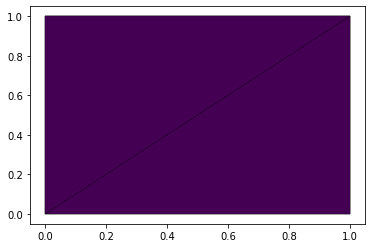

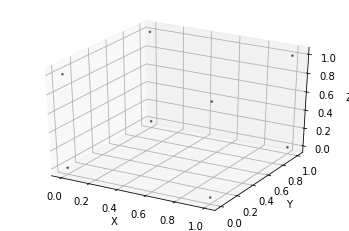

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

# 8 points defining the cube corners
pts = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], ])
hull = ConvexHull(pts)
colors = np.array([50]*len(hull.simplices))
plt.tripcolor(pts[:,0], pts[:,1], hull.simplices.copy(), facecolors=colors, edgecolors='k')
plt.draw()

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
x=pts[:, 0]
y=pts[:, 1]
z=pts[:, 2]
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter(x,y,z, marker='.', s=10, c="black", alpha=0.5)
plt.show()

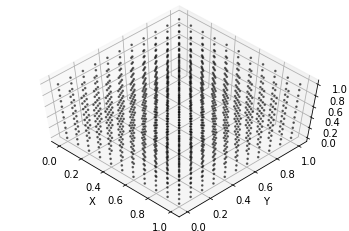

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

a, b=cmesh(11)

points = 1331
data = np.zeros([points,3])
x = a[:, 0]
y = a[:, 1]
z = a[:, 2]

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x,y,z, marker='.', s=10, c="black", alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()